<a href="https://colab.research.google.com/github/Anil1331/Style-Transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!mkdir vgg
from google.colab import files
uploaded = files.upload()

mkdir: cannot create directory ‘vgg’: File exists


Saving style.jpg to style.jpg


In [16]:
import os, requests
import sys
import time
import numpy as np
import scipy.io
import scipy.misc
import skimage.transform
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio

style_img = "style.jpg"
content_img = "content.jpg"
width = 800
height = 600
num_channels = 3
noise_ratio = 0.6
num_iterations = 1000
beta = 7.5
alpha = 100
gamma = 200
mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

def download_vgg():
  url = "http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat"
  filename = "vgg/"+"vgg.mat"
  if(not os.path.exists(filename)):
    r = requests.get("http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat")
    open(filename, "wb").write(r.content)
  vgg = scipy.io.loadmat(filename)
  return vgg

def get_weights(layer, vgg):
  wb = vgg["layers"][0][layer][0][0][2]
  w = wb[0][0]
  b = wb[0][1]
  return w, b

def load_image(path):
    image = imageio.imread(path)
    image = 255 * skimage.transform.resize(image, (height, width, num_channels))
    image = np.reshape(image, ((1,) + image.shape))
    image = image - mean
    return image

def conv_layer(input_layer, layer, vgg):
  w, b = get_weights(layer, vgg)
  w = tf.constant(w)
  b = tf.constant(np.reshape(b, (b.size)))
  return tf.nn.conv2d(input_layer, filter=w, strides=[1, 1, 1, 1], padding='SAME') + b

def batch_conv_pool(input_layer, input_layer_count, num_conv_layers, nn, vgg):  
  for i in range(num_conv_layers):
    conv = tf.nn.relu(conv_layer(input_layer, input_layer_count, vgg))
    input_layer_count = input_layer_count + 2
    input_layer = conv
    nn.append(conv)
  out = tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  nn.append(out)
  input_layer_count = input_layer_count + 1
  return out, input_layer_count

def create_nn(height, width, num_channels, vgg):
  nn = []
  input_data = tf.Variable(np.zeros((1, height, width, num_channels)), dtype = 'float32')
  nn.append(input_data)
  batch1, count = batch_conv_pool(input_data, 0, 2, nn, vgg)
  batch2, count = batch_conv_pool(batch1, count, 2, nn, vgg)
  batch3, count = batch_conv_pool(batch2, count, 4, nn, vgg)
  batch4, count = batch_conv_pool(batch3, count, 4, nn, vgg)
  batch5, count = batch_conv_pool(batch4, count, 4, nn, vgg)
  return nn

def gmm(layer, wh, ch):
  reshaped_layer = tf.reshape(layer, (wh, ch))
  return tf.matmul(tf.transpose(reshaped_layer), reshaped_layer)

def get_style_loss(sess, nn):
  style_layers = [1, 4, 7, 12, 17]
  style_weights = [0.5, 1, 1.5, 3, 4]
  total_loss = 0
  for i, st in enumerate(style_layers):
    layer = nn[st]
    w, h, ch = layer.shape[1].value, layer.shape[2].value, layer.shape[3].value
    wh = w*h
    current = sess.run(layer)
    gmm_c = gmm(current, wh, ch)
    gmm_l = gmm(layer, wh, ch)
    loss = (1/(4 * ch**2 * wh**2)) * tf.reduce_sum(tf.pow(gmm_c - gmm_l, 2))
    total_loss = total_loss + loss*style_weights[i]
  return total_loss

def get_content_loss(sess, nn):
  layer = nn[13]
  w, h, ch = layer.shape[1].value, layer.shape[2].value, layer.shape[3].value
  wh = w*h
  current = sess.run(layer)
  loss = (1 / (4 * ch * wh)) * tf.reduce_sum(tf.pow(layer - current, 2))
  return loss

def get_variatonal_loss(sess, nn):
    return tf.reduce_sum(tf.image.total_variation(nn[0]))
  
def get_input_image(content_image, height, width, num_channels, noise_ratio):
    noise_image = np.random.uniform(-20, 20,
            (1, height, width, num_channels)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image  

def save_image(path, image):
    image = image + mean
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)  
  
def show_image(image):
    image = image + mean
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.close()  
  
def run_training():
  with tf.Session() as sess:
    vgg = download_vgg()
    content_image = load_image(content_img)
    style_image = load_image(style_img)
    nn = create_nn(height, width, num_channels, vgg)
    input_image = get_input_image(content_image, height, width, num_channels, noise_ratio)

    sess.run(tf.global_variables_initializer())
    sess.run(nn[0].assign(style_image))
    style_loss = get_style_loss(sess, nn)
    sess.run(nn[0].assign(content_image))
    content_loss = get_content_loss(sess, nn)
    sess.run(nn[0].assign(input_image))
    total_variational_loss = get_variatonal_loss(sess, nn)

    total_loss = beta * content_loss + alpha * style_loss + gamma * total_variational_loss
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_loss)
    sess.run(tf.global_variables_initializer())
    sess.run(nn[0].assign(input_image))  
    for i in range(1, num_iterations+1):
        sess.run(train_step)
        l, cl, ls, lv = sess.run([total_loss, content_loss, style_loss, total_variational_loss])
        print("It {} l {} cl {} sl {} vl {}".format(i, l, cl, ls, lv))
                       
    generated_image = sess.run(nn[0])
    save_image('generated_image.jpg', generated_image)            
    sess.close()        
          
run_training()          

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


l 683134484480.0 cl 13625.6142578125 sl 6781703680.0 vl 24819924.0
l 605277978624.0 cl 14939.2265625 sl 6002192896.0 vl 25292746.0
l 536453709824.0 cl 16226.1240234375 sl 5313046016.0 vl 25744860.0
l 476450783232.0 cl 17468.119140625 sl 4712124416.0 vl 26191192.0
l 423275593728.0 cl 18636.9609375 sl 4179480320.0 vl 26637170.0
l 375880220672.0 cl 19707.369140625 sl 3704636160.0 vl 27082304.0
l 333854474240.0 cl 20659.712890625 sl 3283492864.0 vl 27525152.0
l 296884600832.0 cl 21491.697265625 sl 2912919552.0 vl 27962388.0
l 264794701824.0 cl 22224.353515625 sl 2591159808.0 vl 28392788.0
l 237521305600.0 cl 22888.681640625 sl 2317575424.0 vl 28817976.0
l 214952673280.0 cl 23519.55078125 sl 2091044992.0 vl 29239952.0
l 196851826688.0 cl 24144.51953125 sl 1909196800.0 vl 29659856.0
l 182772678656.0 cl 24775.90234375 sl 1767568896.0 vl 30078096.0
l 172066471936.0 cl 25405.95703125 sl 1659677056.0 vl 30492834.0
l 163995238400.0 cl 26017.92578125 sl 1578149888.0 vl 30900312.0
l 157800169472.0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


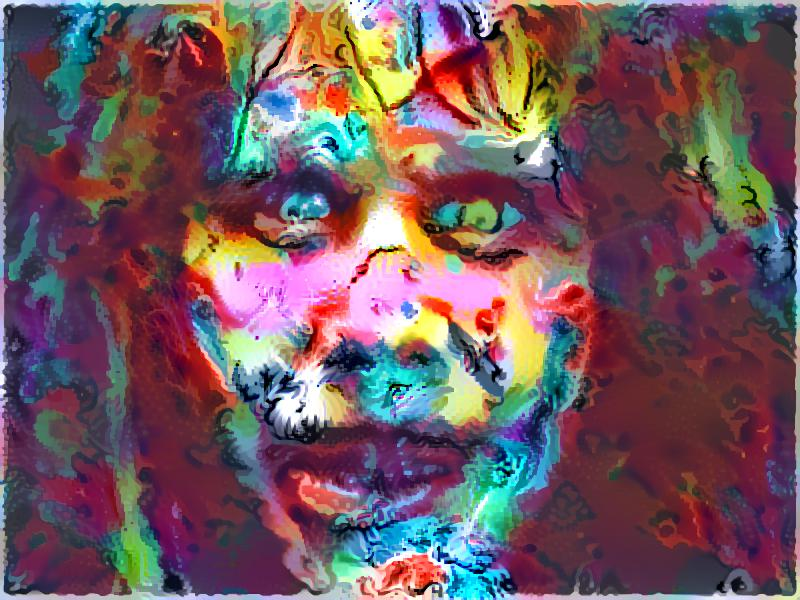

In [18]:
from IPython.display import Image
Image('generated_image.jpg')

In [0]:
files.download("generated_image.jpg")